# Differences between DPI and MDI Inhaler Prescribing in England: 10 Years of Data (2016–2025)

### Introduction

This notebook is an addendum to a [previous analysis of 2023 data](https://github.com/ebmdatalab/prescribing-notebooks/blob/master/notebooks/Final_ACT_Environment_inhaler_2023_Prescribing-V2_SQL.ipynb). Here, we extend that work to cover **10 complete years** of NHS prescribing data (2016–2025), allowing us to track longer-term trends in inhaler device choice across England.

**Why does this matter?** Metered-dose inhalers (MDIs) use hydrofluorocarbon propellants with a significantly higher carbon footprint than dry powder inhalers (DPIs) or soft mist inhalers (SMIs).

**What are we looking at?** We query the [OpenPrescribing](https://openprescribing.net/) dataset in BigQuery, classify every inhaler prescription by its device type (DPI, MDI, or SMI) and therapeutic class, and then visualise how DPI uptake has changed over the decade.

**Entity Relationship Diagram (ERD):**

The diagram below shows how the database tables connect. The prescribing data (`normalised_prescribing`) is linked to the Dictionary of Medicines and Devices (dm+d) tables to identify each product's form/route (which tells us if it's a DPI, MDI, or SMI) and its ATC code (which tells us the therapeutic class).

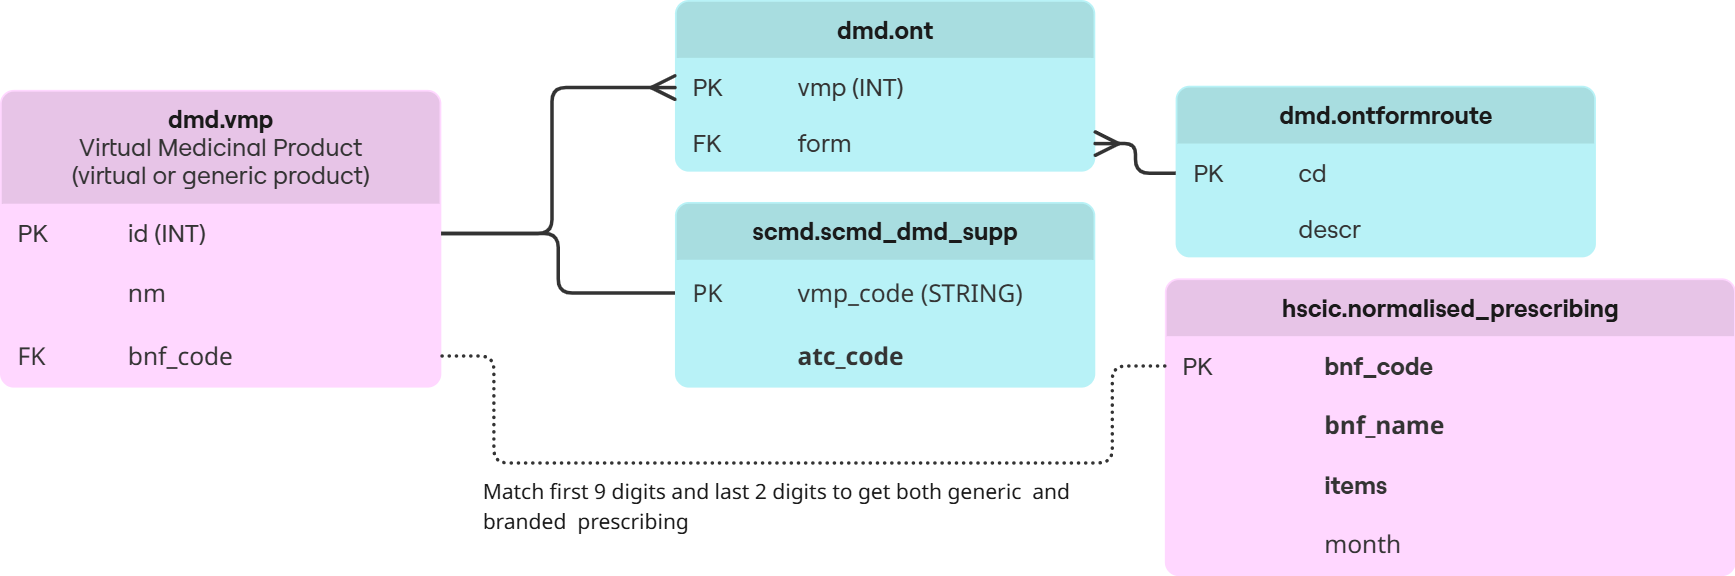

<a id='setup'></a>
### Setting Up Our Tools


In [1]:
# -----------------------------------------------------------------------
# Import the libraries we need
# -----------------------------------------------------------------------
from ebmdatalab import bq           # Connects us to the prescribing database
import pandas as pd                  # Our main tool for handling data tables
import matplotlib.pyplot as plt      # Creates charts and graphs
import matplotlib.ticker as mtick    # Helps format axis labels (e.g. adding "%" to tick marks)
import numpy as np                   # Helps with numerical calculations
import os                            # Manages file paths

# This setting ensures we can see full product names in our results
pd.set_option('display.max_colwidth', None)

<a id='extraction'></a>
### Extracting 2016 to 2025 Prescribing Data

This is the main query that pulls all inhaler prescribing data from the last 10 years. For every inhaler prescribed in England, we capture:

- **Year**: which year the prescription was dispensed
- **Device type**: classified from the dm+d form/route description:
  - **DPI** (Dry Powder Inhaler) e.g. Accuhaler, Turbohaler, Ellipta
  - **MDI** (Metered-Dose Inhaler) e.g. Ventolin Evohaler, Clenil
  - **SMI** (Soft Mist Inhaler) e.g. Spiriva Respimat
- **Therapeutic class**: based on [ATC codes](https://atcddd.fhi.no/atc_ddd_index/), grouping products into clinically meaningful categories:
  - **SABA** (Short-acting beta-agonists): `R03AC0` e.g. salbutamol, terbutaline
  - **LABA** (Long-acting beta-agonists): `R03AC1` e.g. salmeterol, formoterol
  - **Anticholinergic**: `R03BB` e.g. tiotropium, ipratropium
  - **ICS** (Inhaled corticosteroids): `R03BA` e.g. beclometasone, budesonide
  - **Combi_1**: `R03AK` adrenergics combined with corticosteroids (e.g. Symbicort, Seretide)
  - **Combi_2**: `R03AL` adrenergics combined with anticholinergics, including triple combinations (e.g. Anoro, Spiolto, Trelegy, Trimbow)
  - **Other**: anything not in the above groups (useful for quality checks)

**A note on Generic Enerzair Breezhaler:** This product doesn't have an ATC code in the database, so we manually assign it the correct code (`R03AL12`). This was identified in the [previous notebook](https://github.com/ebmdatalab/prescribing-notebooks/blob/master/notebooks/Final_ACT_Environment_inhaler_2023_Prescribing-V2_SQL.ipynb).

In [2]:
# -----------------------------------------------------------------------
# SQL query: Fetch all inhaler prescriptions from 2016–2025
# -----------------------------------------------------------------------
# This query runs against Google BigQuery. If you've run it before, 
# the results are cached locally as a CSV file so you don't need to 
# re-query (and re-pay for) 180 GB of data each time.
# -----------------------------------------------------------------------

sql_all_resp_inhaler_rx_with_atc_code_10yr = """
WITH resp_inhalers AS (
  -- STEP 1: Pull raw prescribing data and classify each product's device type
  SELECT
    EXTRACT(YEAR FROM month) AS year,           -- Extract the year from the monthly prescribing date
    rx.bnf_code,                                -- The BNF code identifying the product
    rx.bnf_name,                                -- The human-readable product name
    
    -- Assign the ATC code. Generic Enerzair Breezhaler (vmp id 39134511000001107)
    -- doesn't have one in the database, so we manually set it to R03AL12.
    CASE
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      ELSE atc.atc_code
    END AS atc_code,
    
    -- Classify the device type based on the dm+d form/route description.
    -- This is how we know whether a product is a DPI, MDI, or SMI.
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'
      ELSE 'OTHER'
    END AS type,
    
    SUM(items) AS total_items                   -- Total number of prescription items dispensed

  FROM `hscic.normalised_prescribing` rx        -- The main prescribing dataset

  -- JOIN to dm+d to get product metadata.
  -- The BNF code matching uses first 9 + last 2 characters to link
  -- branded and generic prescribing to the same virtual medicinal product (VMP).
  LEFT JOIN `dmd.vmp` vmp 
    ON CONCAT(SUBSTR(rx.bnf_code,0,9), SUBSTR(rx.bnf_code,-2)) = 
       CONCAT(SUBSTR(vmp.bnf_code,0,9), SUBSTR(vmp.bnf_code,-2))
  
  LEFT JOIN `dmd.ont` AS o ON vmp.id = o.vmp                    -- Link to ontology (form info)
  LEFT JOIN `dmd.ontformroute` AS r ON o.form = r.cd             -- Get the form/route description
  LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code  -- Get ATC codes

  WHERE EXTRACT(YEAR FROM month) BETWEEN 2016 AND 2025          -- 10-year window
    AND vmp.bnf_code LIKE '03%'                                  -- BNF chapter 3 = respiratory
    AND r.descr IN (                                              -- Only include inhaler form/routes
      'powderinhalation.inhalation',
      'pressurizedinhalation.inhalation',
      'inhalationsolution.inhalation'
    )
  GROUP BY year, bnf_code, bnf_name, atc_code, type
  ORDER BY total_items DESC
)

-- STEP 2: Map each product to a therapeutic class based on its ATC code
SELECT 
  year,
  bnf_code,
  bnf_name,
  atc_code,
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'            -- Short-acting beta-agonists
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'            -- Long-acting beta-agonists
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'  -- Anticholinergics (e.g. tiotropium)
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'              -- Inhaled corticosteroids
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'          -- ICS + LABA combinations
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'          -- Triple combos / LABA + LAMA
    ELSE 'OTHER'                                                  -- Anything else (for QA)
  END AS cat,
  type,
  total_items
FROM resp_inhalers
"""

# Run the query (or load from cache if it's been run before)
all_resp_inhaler_rx_with_atc_code_10yr = bq.cached_read(
    sql_all_resp_inhaler_rx_with_atc_code_10yr,
    csv_path=os.path.join('..', 'data', '10_year_inhaler_data', 'Final_all_resp_inhaler_rx_with_atc_code_10yr.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


**⚠️ This query processes approximately 180 GB when run for the first time.** Results are cached locally as a CSV, so subsequent runs load from the csv file instead of re-querying BigQuery.

Let's preview the first 10 rows to check the data looks sensible. We'd expect to see familiar inhaler names with their BNF codes, ATC codes, device types, and item counts:

In [3]:
# Preview the first 10 rows of our dataset
display(all_resp_inhaler_rx_with_atc_code_10yr.head(10))

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
0,2020,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12952597
1,2019,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12534593
2,2021,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12309571
3,2017,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12309543
4,2016,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12250150
5,2018,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,12215290
6,2022,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,10872399
7,2024,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (Teva),R03AC02,SABA,MDI,8282376
8,2023,0301011R0BIAFAP,Salamol 100micrograms/dose inhaler CFC free (Teva),R03AC02,SABA,MDI,7373702
9,2023,0301011R0AAAPAP,Salbutamol 100micrograms/dose inhaler CFC free,R03AC02,SABA,MDI,7315130


The preview above confirms the data looks as expected. The top rows are dominated by Salbutamol MDIs. This is unsurprising as these are the most commonly prescribed inhalers in England.

<a id='breakdown'></a>
### DPI Uptake by Therapeutic Class

Now that we've grouped products into clinically meaningful categories, the next step is to calculate what **percentage** of items in each category were prescribed as DPIs. .

The SQL below aggregates the data by year and therapeutic class, and calculates the DPI percentage for each group.

In [4]:
# -----------------------------------------------------------------------
# SQL query: Calculate DPI uptake percentage by therapeutic class
# -----------------------------------------------------------------------
# This query uses the same base data as above, but aggregates it
# differently. Instead of individual products, we get one row per
# year/therapeutic class with counts for each device type and a 
# DPI percentage.
# -----------------------------------------------------------------------

sql_DPI_uptake_by_ATC_cluster = """
WITH resp_inhalers AS (
  -- Same base query as before: pull all inhaler prescriptions
  SELECT
    EXTRACT(YEAR FROM month) AS year,
    rx.bnf_code,                    
    rx.bnf_name,                    
    CASE
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      ELSE atc.atc_code
    END AS atc_code,
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'    
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI' 
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'   
    ELSE 'OTHER' END AS type,
    SUM(items) AS total_items
  FROM hscic.normalised_prescribing rx
  LEFT JOIN dmd.vmp vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  LEFT JOIN dmd.ont AS o ON vmp.id = o.vmp
  LEFT JOIN dmd.ontformroute AS r ON o.form = r.cd
  LEFT JOIN scmd.scmd_dmd_supp AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  WHERE EXTRACT(YEAR FROM month) BETWEEN 2016 AND 2025         
    AND vmp.bnf_code LIKE '03%'                 
    AND r.descr IN (                            
      'powderinhalation.inhalation',            
      'pressurizedinhalation.inhalation',       
      'inhalationsolution.inhalation'           
    )
  GROUP BY year, bnf_code, bnf_name, atc_code, type
  ORDER BY total_items DESC
)

-- Now aggregate by year and therapeutic class, calculating device counts and DPI %
SELECT 
  year,
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'Other'
  END AS cluster,          
  
  -- Count items by device type using conditional aggregation
  SUM(CASE WHEN type = 'DPI' THEN total_items ELSE 0 END) AS DPI,
  SUM(CASE WHEN type = 'MDI' THEN total_items ELSE 0 END) AS MDI, 
  SUM(CASE WHEN type = 'SMI' THEN total_items ELSE 0 END) AS SMI,
  
  -- Calculate the percentage of total items that were DPIs
  ROUND(
    100.0 * SUM(CASE WHEN type = 'DPI' THEN total_items ELSE 0 END) / 
    SUM(total_items), 
    1
  ) AS DPI_percentage
  
FROM resp_inhalers         
GROUP BY 
  year,
  CASE
    WHEN SUBSTR(atc_code,0,6) = 'R03AC0' THEN 'SABA'
    WHEN SUBSTR(atc_code,0,6) = 'R03AC1' THEN 'LABA'
    WHEN SUBSTR(atc_code,0,5) = 'R03BB' THEN 'Anticholinergic'
    WHEN SUBSTR(atc_code,0,5) = 'R03BA' THEN 'ICS'
    WHEN SUBSTR(atc_code,0,5) = 'R03AK' THEN 'Combi_1'
    WHEN SUBSTR(atc_code,0,5) = 'R03AL' THEN 'Combi_2'
    ELSE 'Other'
  END
ORDER BY cluster, year
"""

# Run the query (or load from cache)
DPI_uptake_by_ATC_cluster = bq.cached_read(
    sql_DPI_uptake_by_ATC_cluster,
    csv_path=os.path.join('..', 'data', '10_year_inhaler_data', ' Final_DPI_uptake_by_ATC_cluster.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


**⚠️ This query also processes approximately 180 GB when run for the first time.**

In [5]:
# Display the full aggregated results
display(DPI_uptake_by_ATC_cluster)

,year,cluster,DPI,MDI,SMI,DPI_percentage
0,2016,Anticholinergic,5143812,500600,555051,83.0
1,2017,Anticholinergic,5108483,419816,717481,81.8
2,2018,Anticholinergic,4805265,344862,911991,79.3
3,2019,Anticholinergic,4045009,281500,1008215,75.8
4,2020,Anticholinergic,3430756,234043,1120577,71.7
...,...,...,...,...,...,...
65,2021,SABA,1131429,19711876,0,5.4
66,2022,SABA,1354779,20032591,0,6.3
67,2023,SABA,1665854,19311597,0,7.9
68,2024,SABA,1740676,18644358,0,8.5


The table above shows the raw numbers, but it's a lot to take in. Let's pivot the data so we can more easily compare DPI percentages across years and therapeutic classes:

In [6]:
# -----------------------------------------------------------------------
# Reshape the data into a more readable summary table
# -----------------------------------------------------------------------

# Step 1: Keep only the columns year, cluster name, and DPI percentage
df_pct = DPI_uptake_by_ATC_cluster[['year', 'cluster', 'DPI_percentage']]

# Step 2: Pivot the data so that:
#   - Each therapeutic class becomes a ROW
#   - Each year becomes a COLUMN
#   - The values are DPI percentages
df_pivot = df_pct.pivot(
    index='cluster',
    columns='year',
    values='DPI_percentage'
)

# Step 3: Sort years left-to-right in ascending order
df_pivot = df_pivot.sort_index(axis=1)

# Step 4: Round to 1 decimal place for cleaner display
df_pivot = df_pivot.round(1)

# Step 5: Display the summary table
display(df_pivot)

year,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
cluster,,,,,,,,,,
Anticholinergic,83.0,81.8,79.3,75.8,71.7,67.9,63.6,58.8,54.2,49.4
Combi_1,62.0,62.7,63.3,63.0,62.5,62.9,64.1,66.3,68.5,73.4
Combi_2,92.1,87.6,74.7,65.0,59.9,56.4,54.4,54.0,51.8,50.0
ICS,6.7,6.3,6.1,5.8,5.7,5.9,7.4,10.1,10.5,9.9
LABA,33.6,34.6,35.1,35.0,34.7,34.9,35.7,36.8,36.5,37.0
Other,0.2,0.1,0.1,0.1,0.2,0.2,1.3,13.1,46.9,25.0
SABA,6.1,5.9,5.7,5.5,5.5,5.4,6.3,7.9,8.5,9.5


A few things can be noted from this summary table:

- **SABA and ICS** have very low DPI uptake (under 10%) throughout the decade. This is not surprising because the dominant products in these classes (Ventolin/Salamol for SABA, Clenil for ICS) are MDIs. However, there are modest increases from around 2022 onwards, which coincide with the NHS [Investment and Impact Fund (IIF) incentives for primary care networks](https://pharmaceutical-journal.com/article/news/primary-care-networks-incentivised-to-switch-patients-to-more-environmentally-friendly-inhalers). In 2021/22, the IIF rewarded increased prescribing of DPIs and SMIs where clinically appropriate, and specifically incentivised prescribing of lower-carbon salbutamol MDIs. In 2022/23, further incentives targeted ICS prescribing and reductions in avoidable SABA use. The uptick we see in both classes likely reflects these schemes, alongside the introduction of newer DPI options and growing awareness of the environmental impact of MDIs.
- **LABA**  DPI uptake has shown a modest increase — the IIF incentives don't appear to have had a significant impact here, possibly because LABA monotherapy inhalers are less commonly prescribed.
- **Combi_1** ICS+LABA combinations saw a dip from 51% to around 40% in 2021, but has since started recovering, reaching nearly 48% by 2025. The timing of this recovery corresponds with the introduction of the IIF incentive scheme.
- **Anticholinergic** DPI uptake has dropped steadily from 83% to 50%. We'll investigate why below.
- **Combi_2** started at 92% DPI but has fallen to 50%. Again, we'll dig into this further.
- **Other** shows volatile percentages. This is expected since this category contains a small number of miscellaneous products and is sensitive to individual product changes.

<a id='visuals'></a>
### Visualising Our Findings


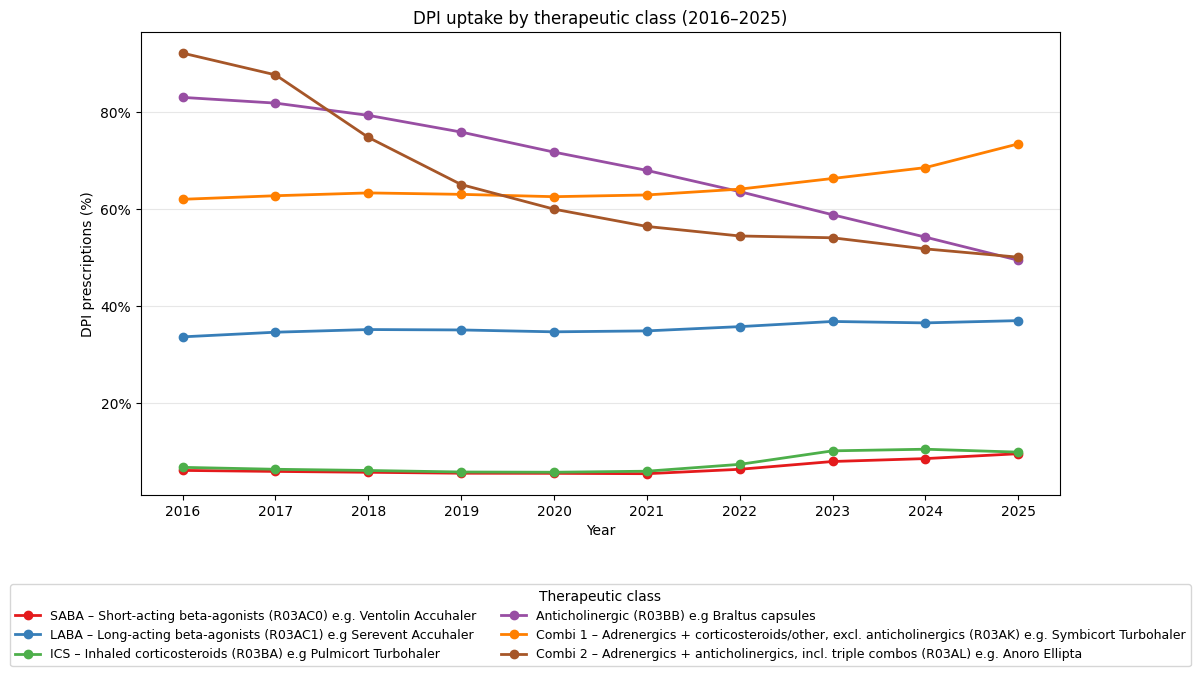

In [7]:
# -----------------------------------------------------------------------
# Chart: DPI uptake (%) by therapeutic class, 2016–2025
# -----------------------------------------------------------------------

# First, aggregate the product-level data by year, therapeutic class, and device type
yearly_cat = all_resp_inhaler_rx_with_atc_code_10yr.groupby(
    ['year', 'cat', 'type']
)['total_items'].sum().reset_index()

# Calculate total items per year/class (the denominator for our percentage)
yearly_totals = yearly_cat.groupby(
    ['year', 'cat']
)['total_items'].sum().reset_index(name='cat_total')

# Calculate DPI items per year/class (the numerator)
yearly_dpi = yearly_cat[yearly_cat['type'] == 'DPI'].groupby(
    ['year', 'cat']
)['total_items'].sum().reset_index(name='dpi_total')

# Merge and calculate the DPI percentage
dpi_pct = yearly_totals.merge(yearly_dpi, on=['year', 'cat'], how='left')
dpi_pct['dpi_total'] = dpi_pct['dpi_total'].fillna(0)       # Classes with no DPIs get 0
dpi_pct['dpi_pct'] = 100 * dpi_pct['dpi_total'] / dpi_pct['cat_total']

# ---- Build the chart ----
fig, ax = plt.subplots(figsize=(12, 7))

# Define the categories and their colours
categories = ['SABA', 'LABA', 'ICS', 'Anticholinergic', 'Combi_1', 'Combi_2']
colours = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']

# Descriptive legend labels so readers can understand each category at a glance
labels = {
    'SABA': 'SABA – Short-acting beta-agonists (R03AC0) e.g. Ventolin Accuhaler',
    'LABA': 'LABA – Long-acting beta-agonists (R03AC1) e.g Serevent Accuhaler',
    'ICS': 'ICS – Inhaled corticosteroids (R03BA) e.g Pulmicort Turbohaler',
    'Anticholinergic': 'Anticholinergic (R03BB) e.g Braltus capsules',
    'Combi_1': 'Combi 1 – Adrenergics + corticosteroids/other, excl. anticholinergics (R03AK) e.g. Symbicort Turbohaler',
    'Combi_2': 'Combi 2 – Adrenergics + anticholinergics, incl. triple combos (R03AL) e.g. Anoro Ellipta',
}

# Plot a line for each therapeutic class
for cat, colour in zip(categories, colours):
    data = dpi_pct[dpi_pct['cat'] == cat].sort_values('year')
    if not data.empty:
        ax.plot(data['year'], data['dpi_pct'], marker='o', label=labels[cat], color=colour, linewidth=2)

# Format the chart
ax.set_xlabel('Year')
ax.set_ylabel('DPI prescriptions (%)')
ax.set_title('DPI uptake by therapeutic class (2016–2025)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticks(range(2016, 2026))
ax.grid(axis='y', alpha=0.3)

# Place the legend below the chart so it doesn't obscure the data
ax.legend(
    title='Therapeutic class',
    bbox_to_anchor=(0.5, -0.18),
    loc='upper center',
    ncol=2,
    fontsize=9
)

plt.tight_layout()
plt.show()

The declining DPI share in anticholinergics and Combi_2 raises some interesting questions, which we'll explore next.

<a id='deepdives'></a>
### Investigating the Declining DPI Trends

#### 1. Are anticholinergic prescribing volumes declining overall?

LAMA (long-acting muscarinic antagonist) monotherapy isn't usually recommended, so we might expect overall volumes to be falling. But there's another possibility: soft mist inhalers (SMIs) like Spiriva Respimat are considered environmentally friendly so it could be SMI growth that's "eating into" the DPI share rather than MDIs increasing.

The two charts below look at anticholinergic prescribing in two ways: absolute volumes by device type (left) and percentage share (right).

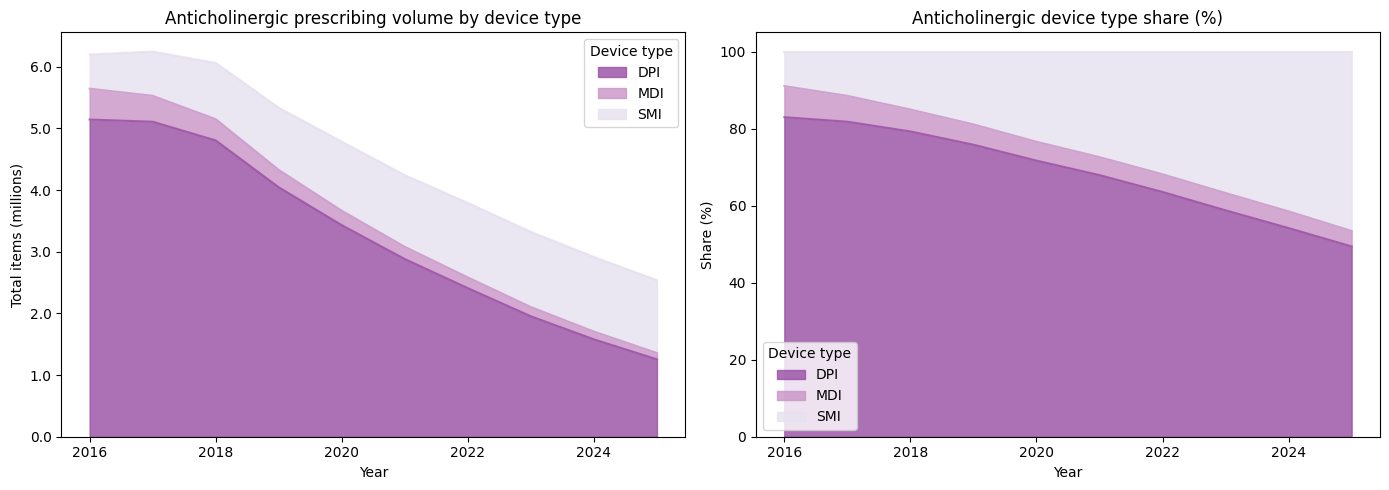

In [8]:
# -----------------------------------------------------------------------
# Chart: Anticholinergic prescribing — volumes and device type share
# -----------------------------------------------------------------------

# Filter the aggregated data to just anticholinergics
antichol = yearly_cat[yearly_cat['cat'] == 'Anticholinergic'].copy()

# Pivot to get device types as columns (DPI, MDI, SMI) with years as rows
antichol_pivot = antichol.pivot_table(
    index='year', columns='type', values='total_items', aggfunc='sum', fill_value=0
)

# Create a figure with two side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Use purple tones for anticholinergic charts
area_colours = {'DPI': '#984ea3', 'MDI': '#c994c7', 'SMI': '#e7e1ef'}

# LEFT chart: Absolute volumes by device type (stacked area)
# This shows whether overall prescribing is growing or shrinking
antichol_pivot.plot.area(ax=ax1, color=area_colours, alpha=0.8)
ax1.set_title('Anticholinergic prescribing volume by device type')
ax1.set_ylabel('Total items (millions)')
ax1.set_xlabel('Year')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{x/1e6:.1f}'))
ax1.legend(title='Device type')

# RIGHT chart: Percentage share by device type (stacked area)
# This shows whether the mix of device types is shifting
antichol_pct = antichol_pivot.div(antichol_pivot.sum(axis=1), axis=0) * 100
antichol_pct.plot.area(ax=ax2, color=area_colours, alpha=0.8)
ax2.set_title('Anticholinergic device type share (%)')
ax2.set_ylabel('Share (%)')
ax2.set_xlabel('Year')
ax2.legend(title='Device type')

plt.tight_layout()
plt.show()

The left chart tells us that overall anticholinergic inhaler prescribing has been declining fairly steadily. 

The right chart is revealing: while DPI's share has shrunk, it's **not MDIs** that have grown to replace them — it's **SMIs**. The pale purple SMI wedge has expanded significantly. Since SMIs don't use propellant gases, this shift isn't necessarily bad from an environmental perspective, even though it shows up as a "decline" in DPI percentage.

#### 2. Is SMI growth driving the DPI decline in anticholinergics?

Let's look at this more directly with a line chart showing each device type's percentage share over time:

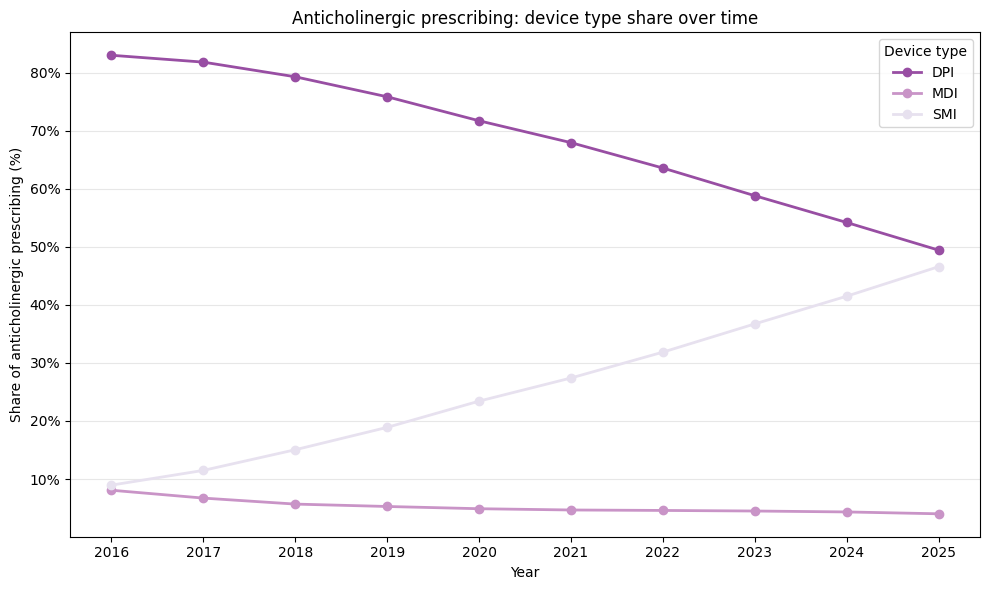

In [9]:
# -----------------------------------------------------------------------
# Chart: Anticholinergic device type share over time (line chart)
# -----------------------------------------------------------------------

# Calculate the percentage share for each device type per year
antichol_detail = antichol.groupby(['year', 'type'])['total_items'].sum().reset_index()
antichol_totals = antichol_detail.groupby('year')['total_items'].sum().reset_index(name='yearly_total')
antichol_detail = antichol_detail.merge(antichol_totals, on='year')
antichol_detail['pct'] = 100 * antichol_detail['total_items'] / antichol_detail['yearly_total']

# Plot each device type as a separate line
fig, ax = plt.subplots(figsize=(10, 6))
type_colours = {'DPI': '#984ea3', 'MDI': '#c994c7', 'SMI': '#e7e1ef'}

for device_type, colour in type_colours.items():
    data = antichol_detail[antichol_detail['type'] == device_type].sort_values('year')
    if not data.empty:
        ax.plot(data['year'], data['pct'], marker='o', label=device_type, color=colour, linewidth=2)

ax.set_title('Anticholinergic prescribing: device type share over time')
ax.set_xlabel('Year')
ax.set_ylabel('Share of anticholinergic prescribing (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticks(range(2016, 2026))
ax.legend(title='Device type')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

The line chart makes the trend very clear: SMI use has been steadily increasing , while DPI use has declined by a roughly corresponding amount. MDI use has also declined slightly. So the "decline in DPI percentage" for anticholinergics is largely being driven by the growth of SMIs — not by a switch back to MDIs.

#### 3. Combi_2: What's driving the reduction?

The Combi_2 category (triple combinations and LABA+LAMA duos) has also seen a big drop in DPI share — from 92% to about 50%. The triple therapy combinations are a relatively new therapeutic class, so the product landscape has changed substantially over the decade. Let's look at the specific products driving this trend:

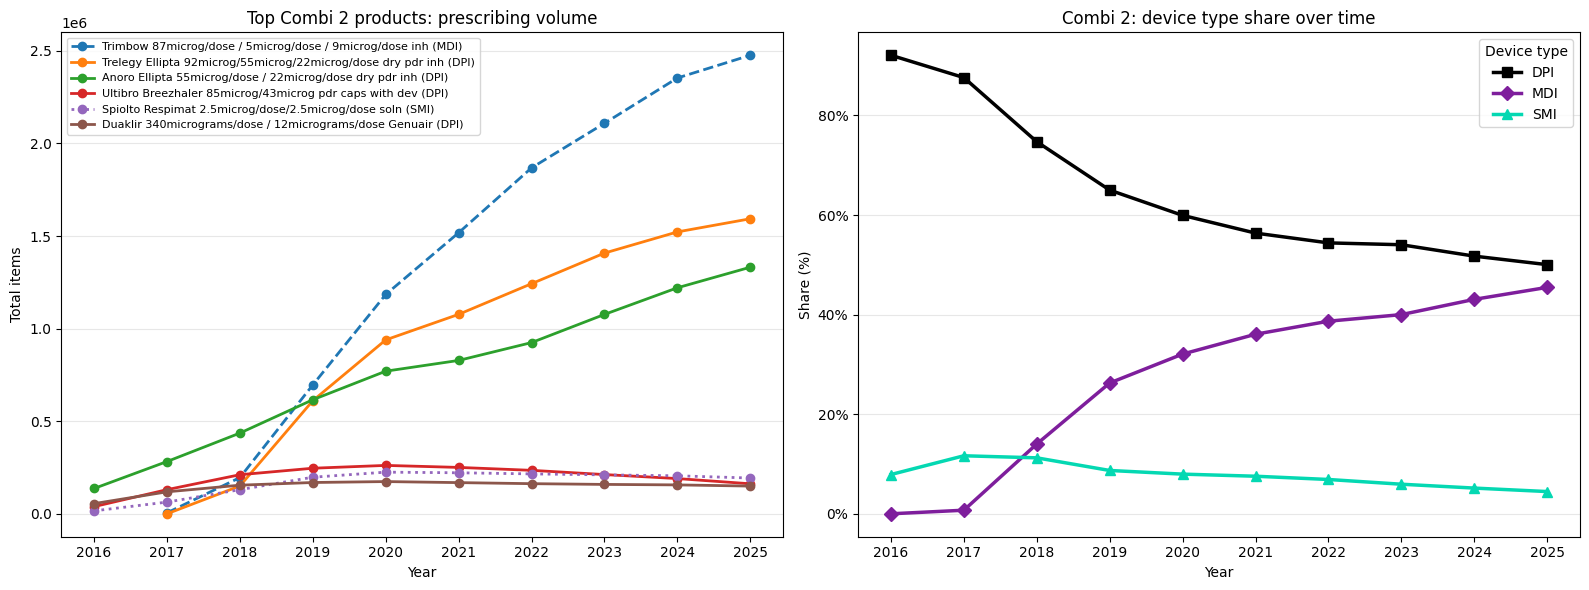

In [10]:
# -----------------------------------------------------------------------
# Charts: Combi_2 product-level trends and device type share
# -----------------------------------------------------------------------

# Filter to just Combi_2 products
combi2 = all_resp_inhaler_rx_with_atc_code_10yr[
    all_resp_inhaler_rx_with_atc_code_10yr['cat'] == 'Combi_2'
].copy()

# Get total items per product per year
combi2_products = combi2.groupby(['year', 'bnf_name', 'type'])['total_items'].sum().reset_index()

# Identify the top 6 products overall (to keep the chart readable)
top_combi2 = combi2_products.groupby('bnf_name')['total_items'].sum().nlargest(6).index
combi2_top = combi2_products[combi2_products['bnf_name'].isin(top_combi2)]

# Create two side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ---- LEFT chart: Individual product volumes ----
# Solid lines = DPI, dashed = MDI, dotted = SMI
for name in top_combi2:
    data = combi2_top[combi2_top['bnf_name'] == name].sort_values('year')
    device = data['type'].iloc[0]
    linestyle = '-' if device == 'DPI' else '--' if device == 'MDI' else ':'
    ax1.plot(data['year'], data['total_items'], marker='o', 
             label=f"{name} ({device})", linewidth=2, linestyle=linestyle)

ax1.set_title('Top Combi 2 products: prescribing volume')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total items')
ax1.set_xticks(range(2016, 2026))
ax1.legend(fontsize=8, loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# ---- RIGHT chart: Device type share within Combi_2 ----
combi2_by_type = combi2.groupby(['year', 'type'])['total_items'].sum().reset_index()
combi2_yearly = combi2_by_type.groupby('year')['total_items'].sum().reset_index(name='yearly_total')
combi2_by_type = combi2_by_type.merge(combi2_yearly, on='year')
combi2_by_type['pct'] = 100 * combi2_by_type['total_items'] / combi2_by_type['yearly_total']

# Use distinct colours and markers for clarity
device_styles = {
    'DPI': {'color': '#000000', 'marker': 's'},       # Black squares
    'MDI': {'color': '#7e1e9c', 'marker': 'D'},       # Purple diamonds
    'SMI': {'color': '#04d8b2', 'marker': '^'},        # Teal triangles
}

for device_type, style in device_styles.items():
    data = combi2_by_type[combi2_by_type['type'] == device_type].sort_values('year')
    if not data.empty:
        ax2.plot(data['year'], data['pct'], 
                 marker=style['marker'], label=device_type, 
                 linewidth=2.5, color=style['color'], markersize=7)

ax2.set_title('Combi 2: device type share over time')
ax2.set_xlabel('Year')
ax2.set_ylabel('Share (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax2.set_xticks(range(2016, 2026))
ax2.legend(title='Device type')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**What does this show?**

The left chart tells the product-level story: the Combi_2 class was initially dominated by DPI products like Anoro Ellipta and Ultibro Breezhaler, but Trimbow (an MDI triple combination) has seen rapid growth since its launch around 2018–2019, and is now one of the most prescribed products in this class. Trelegy Ellipta (a DPI triple) has also grown strongly, but Trimbow's MDI volumes have been higher.

The right chart confirms the overall shift: DPI's share of Combi_2 prescribing has fallen from over 90% to roughly 50%, with MDIs gaining the corresponding share. Unlike the anticholinergic story, this appears to be a genuine shift towards MDIs — Trimbow's popularity as an MDI triple inhaler is the primary driver.


<a id='qa'></a>
## Quality Assurance 

In this section, we run  checks to make sure our therapeutic groupings and device classifications are accurate.

**Check 1: Review the "Other" category.** Any product that doesn't match our ATC code patterns ends up here. If we find well-known inhalers in "Other", it means our classification logic has a gap that needs fixing. (For example, in the [previous 2023 analysis](https://github.com/ebmdatalab/prescribing-notebooks/blob/master/notebooks/Final_ACT_Environment_inhaler_2023_Prescribing-V2_SQL.ipynb), we identified Generic Enerzair Breezhaler in the Other category because it lacked an ATC code — that's now been corrected with the manual override in our SQL.)

**Check 2: Verify discontinued inhalers are correctly captured.** Since we're now looking back 10 years, some inhalers from that period have since been discontinued (e.g. Diskalers, Clickhalers). We need to make sure these products still have ATC codes and form/route data in the database, so they're not silently dropped from our analysis.

**Check 3: Review the top 10 most prescribed inhalers per category per year.** This is a manual sense-check — do the top products look right? Are there any surprising omissions or misclassifications?

#### Check 1: Review the "Other" category

In [11]:
# -----------------------------------------------------------------------
# QA Check 1: What's in the "Other" category?
# -----------------------------------------------------------------------
# Filter to just products classified as "OTHER" — these are products 
# whose ATC codes didn't match any of our therapeutic class patterns.
# -----------------------------------------------------------------------

other_category = all_resp_inhaler_rx_with_atc_code_10yr[
    all_resp_inhaler_rx_with_atc_code_10yr['cat'] == 'OTHER'
]

# Display all rows without truncation so we can inspect every product
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(other_category)

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
1418,2018,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,5130
1433,2019,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4946
1442,2020,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4745
1444,2016,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4679
1445,2017,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,4676
1473,2021,0303010Q0AAANAN,Sodium cromoglicate 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,3919
1497,2016,0303010J0AAADAD,Nedocromil 2mg/dose inhaler CFC free,R03BC03,OTHER,MDI,3184
1522,2017,0303010J0AAADAD,Nedocromil 2mg/dose inhaler CFC free,R03BC03,OTHER,MDI,2699
1545,2018,0303010Q0BBALAN,Intal 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,2420
1557,2019,0303010Q0BBALAN,Intal 5mg/dose inhaler CFC free,R03BC01,OTHER,MDI,2266


**Result:** An examination of the list above shows that no unexpected products appear in the Other category. The products here are correctly unclassifiable within our main therapeutic groups (e.g. cromoglicate inhalers, which have the ATC prefix `R03BC` rather than any of our target prefixes).

#### Check 2: Verify discontinued inhalers are correctly captured

We'll filter the main dataset for products containing "disk" or "clickhaler" in the name — these are well-known discontinued DPI inhalers that were commonly prescribed in the earlier part of our 10-year window. We want to confirm they have both an ATC code (for classification) and a device type (from the dm+d form/route data):

In [12]:
# -----------------------------------------------------------------------
# QA Check 2: Are discontinued inhalers (Diskalers, Clickhalers) captured?
# -----------------------------------------------------------------------

# Ensure full product names are displayed
pd.set_option('display.max_colwidth', None)

# Search for products containing "disk" or "clickhaler" (case-insensitive)
# This catches Diskalers, Diskhalers, Clickhalers etc.
mask = all_resp_inhaler_rx_with_atc_code_10yr['bnf_name'].str.contains(
    'disk|clickhaler', 
    case=False,      # Case-insensitive search
    na=False         # Don't error on missing values
)

# Apply the filter and display results
filtered_df = all_resp_inhaler_rx_with_atc_code_10yr[mask]
filtered_df

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
1495,2016,0302000C0BIAEBJ,Asmabec 100 Clickhaler,R03BA01,ICS,DPI,3231
1646,2016,0301011R0BJABAF,Asmasal 95micrograms/dose Clickhaler,R03AC02,SABA,DPI,1369
1831,2017,0302000C0BIAEBJ,Asmabec 100 Clickhaler,R03BA01,ICS,DPI,363
1885,2017,0301011R0BJABAF,Asmasal 95micrograms/dose Clickhaler,R03AC02,SABA,DPI,161
1936,2016,0301011U0BBAAAA,Serevent 50microgram disks with Diskhaler,R03AC12,LABA,DPI,47
1970,2016,0301011U0BBABAB,Serevent 50microgram disks,R03AC12,LABA,DPI,27
1971,2016,0302000C0BIAFBK,Asmabec 250 Clickhaler,R03BA01,ICS,DPI,25
1993,2018,0302000C0BIAEBJ,Asmabec 100 Clickhaler,R03BA01,ICS,DPI,20
2015,2018,0301011R0BJABAF,Asmasal 95micrograms/dose Clickhaler,R03AC02,SABA,DPI,16
2050,2019,0302000C0BIAEBJ,Asmabec 100 Clickhaler,R03BA01,ICS,DPI,12


The sample of discontinued powder inhalers has been correctly classified. They all have ATC codes and are correctly identified as DPIs. This confirms that the dm+d historical data is intact for these products and they aren't being silently dropped from our analysis.

#### Check 3: Top 10 most prescribed inhalers per category per year

This is our broadest sense-check. We sort all products by volume within each year/category combination and keep the top 10. We then save this as a CSV file for reference and display it below for manual review:

In [13]:
# -----------------------------------------------------------------------
# QA Check 3: Top 10 most prescribed inhalers per category, per year
# -----------------------------------------------------------------------
# This helps us spot any obvious misclassifications or missing products.
# We also save the result as a CSV for reference.
# -----------------------------------------------------------------------

top_10_inhaler_prescribing_per_cluster_10yr = (
    all_resp_inhaler_rx_with_atc_code_10yr
    .sort_values('total_items', ascending=False)        # Sort by volume (highest first)
    .groupby(['year', 'cat'])                           # Group by year and therapeutic class
    .head(10)                                            # Keep top 10 per group
    .sort_values(['year', 'cat', 'total_items'],        # Re-sort for display
                 ascending=[True, True, False])
    .reset_index(drop=True)
)

# Save to CSV for reference
top_10_inhaler_prescribing_per_cluster_10yr.to_csv(
    os.path.join('..', 'data', '10_year_inhaler_data', 'interim_file_top_10_inhaler_prescribing_per_cluster_10yr.csv'),
    index=False
)

In [14]:
# Display the full top-10 table without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(top_10_inhaler_prescribing_per_cluster_10yr)

,year,bnf_code,bnf_name,atc_code,cat,type,total_items
0,2016,0301020Q0AAABAB,Tiotropium bromide 18microgram inhalation powder capsules,R03BB04,Anticholinergic,DPI,3336211
1,2016,0301020Q0AAAAAA,Tiotropium bromide 18microgram inhalation pdr caps with dev,R03BB04,Anticholinergic,DPI,518858
2,2016,0301020I0AAANAN,Ipratropium bromide 20micrograms/dose inhaler CFC free,R03BB01,Anticholinergic,MDI,436841
3,2016,0301020Q0AAACAC,Tiotropium brom 2.5microg/dose soln for inhalation CFCfree,R03BB04,Anticholinergic,SMI,338189
4,2016,0301020Q0BBABAB,Spiriva 18microgram inhalation powder capsules,R03BB04,Anticholinergic,DPI,272570
5,2016,0301020S0BBAAAA,Seebri Breezhaler 44microgram inhalation pdr caps with dev,R03BB06,Anticholinergic,DPI,250601
6,2016,0301020Q0BBACAC,Spiriva Respimat 2.5microg/dose inhalation soln,R03BB04,Anticholinergic,SMI,216862
7,2016,0301020R0BBAAAA,Eklira 322micrograms/dose Genuair,R03BB05,Anticholinergic,DPI,198558
8,2016,0301020T0BBAAAA,Incruse Ellipta 55micrograms/dose dry powder inhaler,R03BB07,Anticholinergic,DPI,197009
9,2016,0301020R0AAAAAA,Aclidinium bromide 375micrograms/dose dry powder inhaler,R03BB05,Anticholinergic,DPI,142676


# !!!!FOSTAIR IS MISSING!!!

#### Check 4: Discontinued inhaler data quality check

As a final check, we run a dedicated SQL query to look for any products where data quality might be compromised — specifically, products that are missing an ATC code, missing a form/route classification, or flagged as discontinued in the dm+d `ampp` table:

In [15]:
# -----------------------------------------------------------------------
# QA Check 4: Identify products with missing ATC codes, missing 
# form/route data, or discontinued status in the dm+d
# -----------------------------------------------------------------------
# This query flags potential data quality issues that could cause
# products to be excluded or misclassified in our main analysis.
# -----------------------------------------------------------------------

sql_discontinued_check = """
WITH resp_inhalers AS (
  SELECT
    EXTRACT(YEAR FROM month) AS year,
    rx.bnf_code,
    rx.bnf_name,
    CASE
      WHEN vmp.id = 39134511000001107 THEN 'R03AL12'
      ELSE atc.atc_code
    END AS atc_code,
    CASE 
      WHEN r.descr = 'powderinhalation.inhalation' THEN 'DPI'
      WHEN r.descr = 'pressurizedinhalation.inhalation' THEN 'MDI'
      WHEN r.descr = 'inhalationsolution.inhalation' THEN 'SMI'
    ELSE 'OTHER' END AS type,
    SUM(items) AS total_items
  FROM `hscic.normalised_prescribing` rx
  LEFT JOIN `dmd.vmp` vmp ON CONCAT(SUBSTR(rx.bnf_code,0,9),SUBSTR(rx.bnf_code,-2)) = 
                             CONCAT(SUBSTR(vmp.bnf_code,0,9),SUBSTR(vmp.bnf_code,-2))
  LEFT JOIN `dmd.ont` AS o ON vmp.id = o.vmp
  LEFT JOIN `dmd.ontformroute` AS r ON o.form = r.cd
  LEFT JOIN `scmd.scmd_dmd_supp` AS atc ON CAST(vmp.id AS STRING) = atc.vmp_code
  WHERE EXTRACT(YEAR FROM month) BETWEEN 2016 AND 2025
    AND vmp.bnf_code LIKE '03%'
    AND r.descr IN (
      'powderinhalation.inhalation',
      'pressurizedinhalation.inhalation',
      'inhalationsolution.inhalation'
    )
  GROUP BY year, bnf_code, bnf_name, atc_code, type
)

-- Flag products with data quality issues
SELECT
  ri.year,
  ri.bnf_code,
  ri.bnf_name,
  ri.atc_code,
  ri.type,
  ri.total_items,
  CASE WHEN ampp.disc = 1 THEN 'Discontinued' ELSE 'Active' END AS disc_status,
  CASE 
    WHEN ri.atc_code IS NULL THEN 'Missing ATC code'
    WHEN ri.type = 'OTHER' THEN 'Missing form/route'
    ELSE 'Complete'
  END AS data_quality
FROM resp_inhalers ri
LEFT JOIN `dmd.ampp` ampp ON ri.bnf_code = ampp.bnf_code
WHERE ri.atc_code IS NULL            -- Missing ATC code
   OR ri.type = 'OTHER'              -- Missing form/route classification
   OR ampp.disc = 1                  -- Discontinued in dm+d
GROUP BY ri.year, ri.bnf_code, ri.bnf_name, ri.atc_code, ri.type, ri.total_items, disc_status, data_quality
ORDER BY ri.year, ri.total_items DESC
"""

DPI_discontinued_check = bq.cached_read(
    sql_discontinued_check,
    csv_path=os.path.join('..', 'data', '10_year_inhaler_data', ' Final_DPI_discontinued_check.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


## End of Notebook


*AI was used to help write the SQL and python code and also to help improve clarity of the text.*